<a href="https://colab.research.google.com/github/keysenelvial/dinam/blob/main/dinam2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Лабораторная работа №2**

Провести классификацию(не регрессию) найденного датасета, методом машины опорных векторов. В формате Markdown писать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.

In [25]:
!pip install pmdarima

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.7 MB/s eta 0:00:00


In [11]:
# Загрузка и предобработка данных
data = pd.read_csv("/content/drive/MyDrive/AMZN.csv", sep=";", header=None, names=["DATE", "TIME", "OPEN", "HIGH", "LOW", "CLOSE", "VOL"])
data['DATETIME'] = pd.to_datetime(data['DATE'].astype(str) + data['TIME'].astype(str), format='%y%m%d%H%M%S')
data.sort_values(by="DATETIME", inplace=True)
data.set_index("DATETIME", inplace=True)

# Выбираем только цены закрытия для анализа
ts = data['CLOSE']
print(ts.head())

DATETIME
2024-07-31 09:30:00    185.27
2024-07-31 09:31:00    185.37
2024-07-31 09:32:00    184.99
2024-07-31 09:33:00    184.88
2024-07-31 09:34:00    184.60
Name: CLOSE, dtype: float64


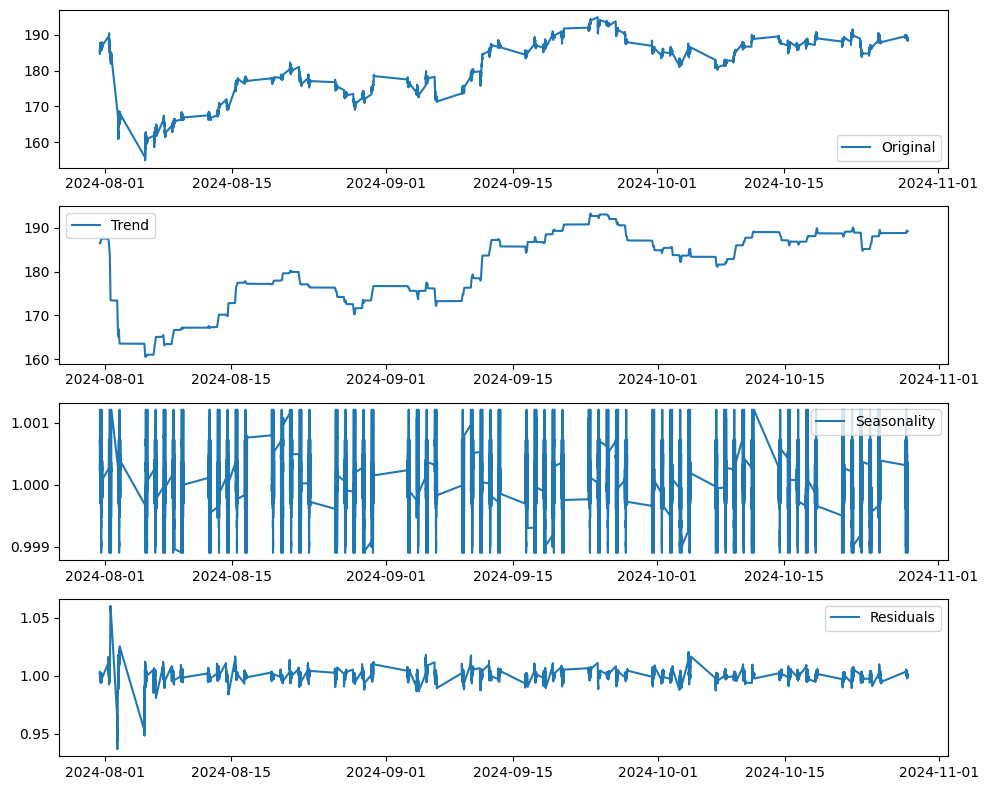

In [14]:
# Декомпозиция временного ряда
decomposition = seasonal_decompose(ts, model='multiplicative', period=252)  # Период 252 для дневных данных, предполагая годовой цикл
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Визуализация декомпозиции
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


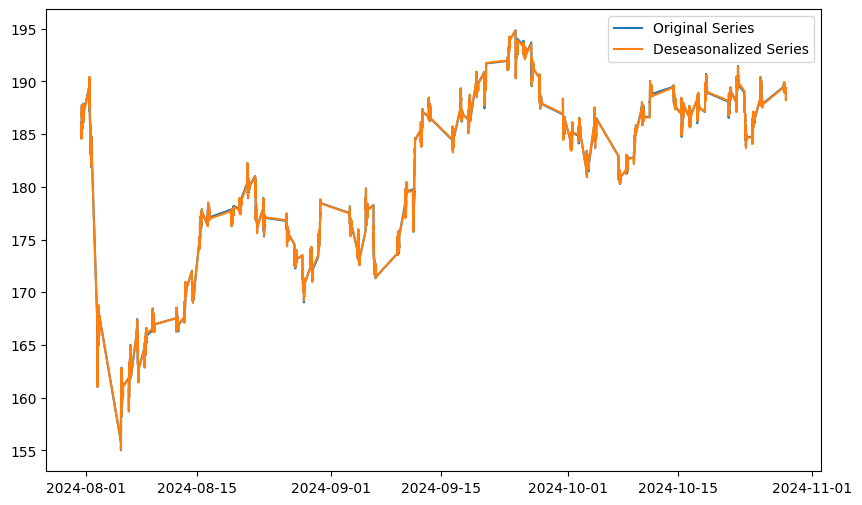

In [15]:
# Десезонирование ряда
deseasonalized = ts / seasonal

# Сравнение исходного ряда и десезонированного
plt.figure(figsize=(10, 6))
plt.plot(ts, label='Original Series')
plt.plot(deseasonalized, label='Deseasonalized Series')
plt.legend(loc='best')
plt.show()

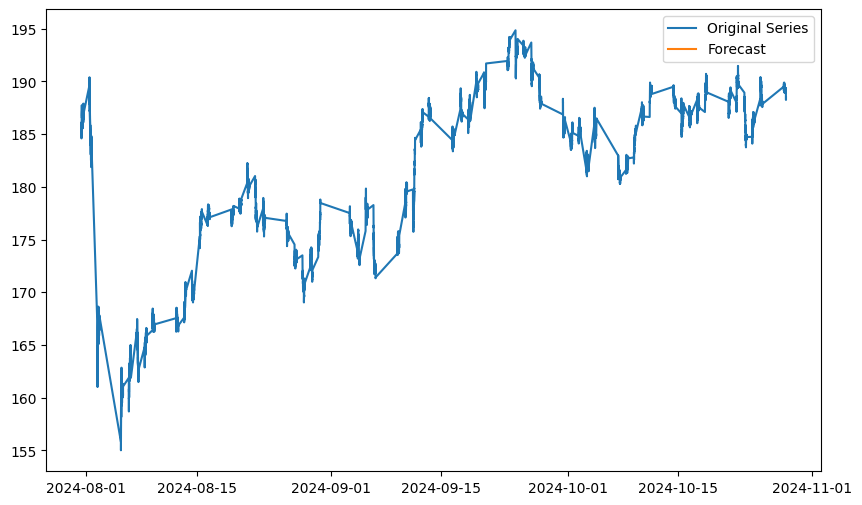

MAE: 0.7474686431185494, RMSE: 0.7730422482752415


In [18]:
# Прогнозирование на основе тренда и сезонности на 12 периодов вперед
future_trend = trend.dropna().values[-1] * np.ones(12)
future_seasonal = seasonal[:12]
forecast = future_trend * future_seasonal

# Визуализация прогноза
plt.figure(figsize=(10, 6))
plt.plot(ts, label='Original Series')
plt.plot(pd.Series(forecast, index=pd.date_range(ts.index[-1], periods=12, freq='B')), label='Forecast')
plt.legend(loc='best')
plt.show()

# Оценка прогноза с помощью MAE и RMSE
mae = mean_absolute_error(ts[-12:], forecast)
rmse = math.sqrt(mean_squared_error(ts[-12:], forecast))
print(f"MAE: {mae}, RMSE: {rmse}")

ADF Statistic: -1.894774474951892
p-value: 0.334523341768844
Серия была преобразована для стационарности
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-7419.772, Time=10.87 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-7422.349, Time=1.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-7420.975, Time=0.61 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-7420.981, Time=1.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-7418.840, Time=3.44 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-7420.359, Time=5.97 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 23.040 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                24446
Model:                        SARIMAX   Log Likelihood                3712.174
Date:                Wed, 13 Nov 2024   AIC                          -7422.349
Time:                        04:01:23   BIC            

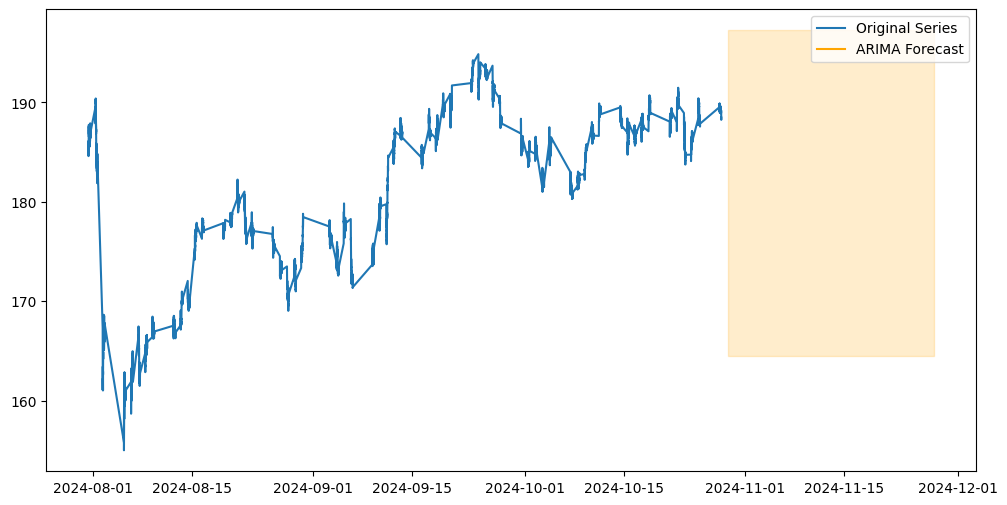

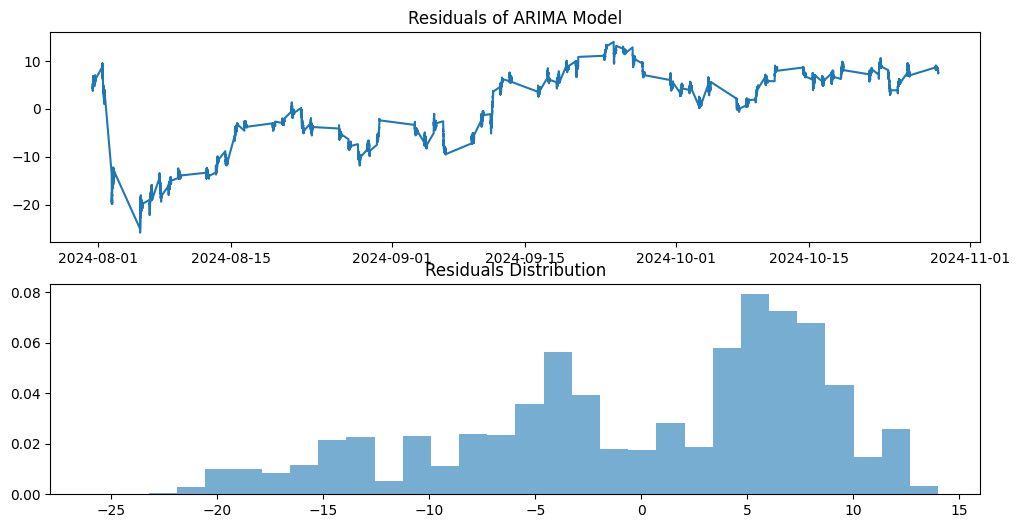

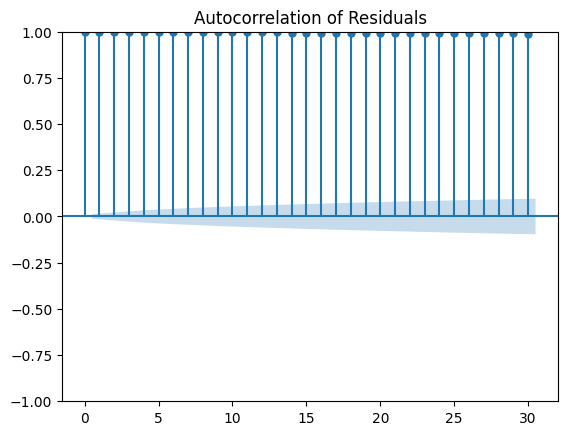

In [26]:
series=ts

# Step 1: Проверка стационарности
def check_stationarity(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    return result[1] < 0.05

if not check_stationarity(series):
    # Применяем разностное преобразование для приведения к стационарности
    series_diff = series.diff().dropna()
    print("Серия была преобразована для стационарности")
else:
    series_diff = series

# Step 2: Автоматический подбор параметров ARIMA
model = auto_arima(series_diff, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print(model.summary())

# Step 3: Построение модели ARIMA с оптимальными параметрами
best_order = model.order
arima_model = ARIMA(series, order=best_order)
arima_fitted = arima_model.fit()

# Step 4: Прогнозирование на N шагов вперед
N = 30  # количество дней для прогноза
forecast = arima_fitted.get_forecast(steps=N)
forecast_index = pd.date_range(series.index[-1], periods=N+1, freq='D')[1:]  # коррекция на частоту ваших данных
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
forecast_ci = forecast.conf_int(alpha=0.05)

# Step 5: Визуализация
plt.figure(figsize=(12, 6))
plt.plot(series, label="Original Series")
plt.plot(forecast_series, color='orange', label="ARIMA Forecast")
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='orange', alpha=0.2)
plt.legend()
plt.show()

# Step 6: Проверка остатков на наличие автокорреляции
residuals = arima_fitted.resid
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(residuals)
plt.title("Residuals of ARIMA Model")

plt.subplot(2, 1, 2)
plt.hist(residuals, bins=30, density=True, alpha=0.6)
plt.title("Residuals Distribution")
plt.show()

# Step 7: Проверка на автокорреляцию остатков
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=30)
plt.title("Autocorrelation of Residuals")
plt.show()

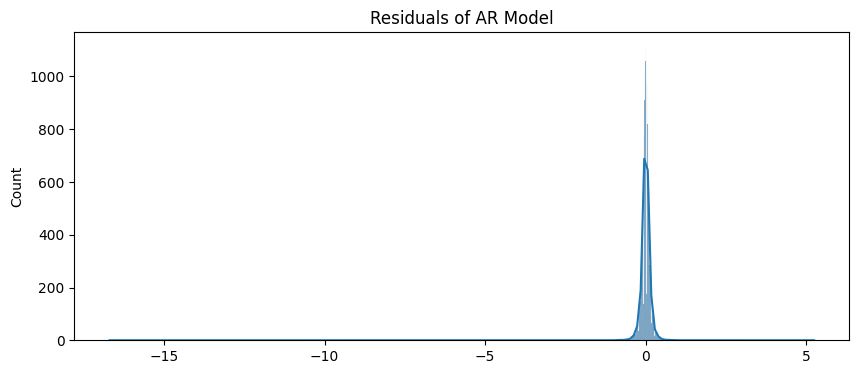

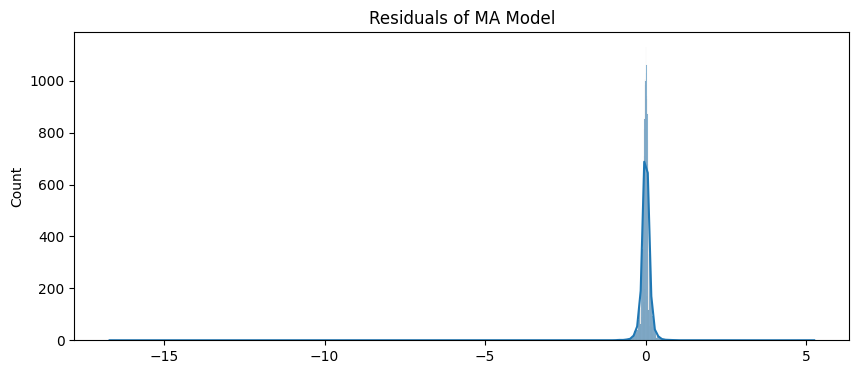

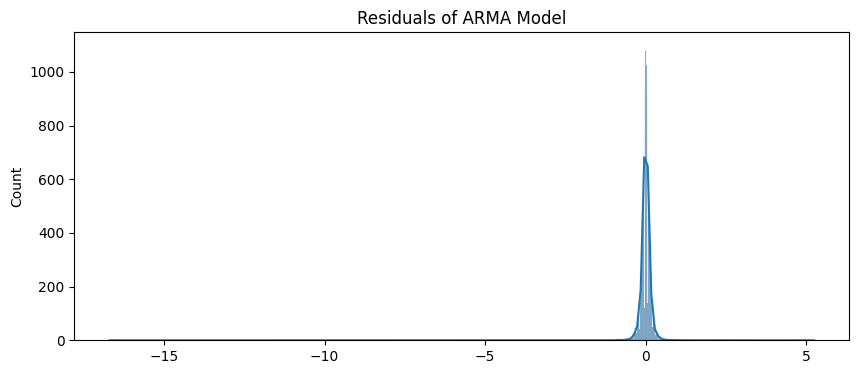

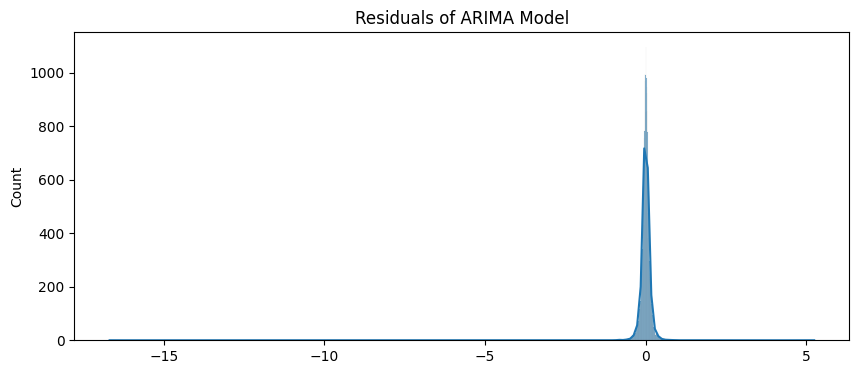

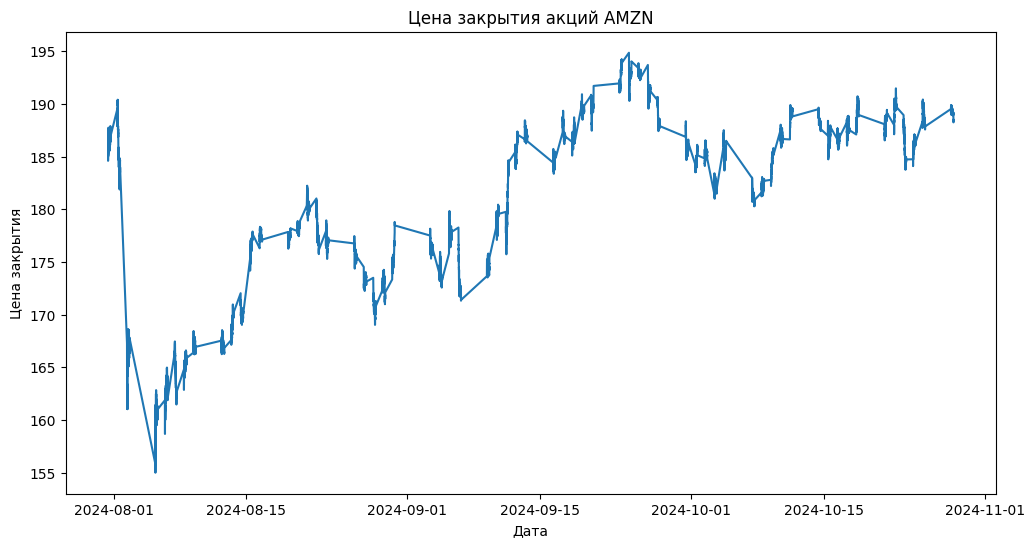

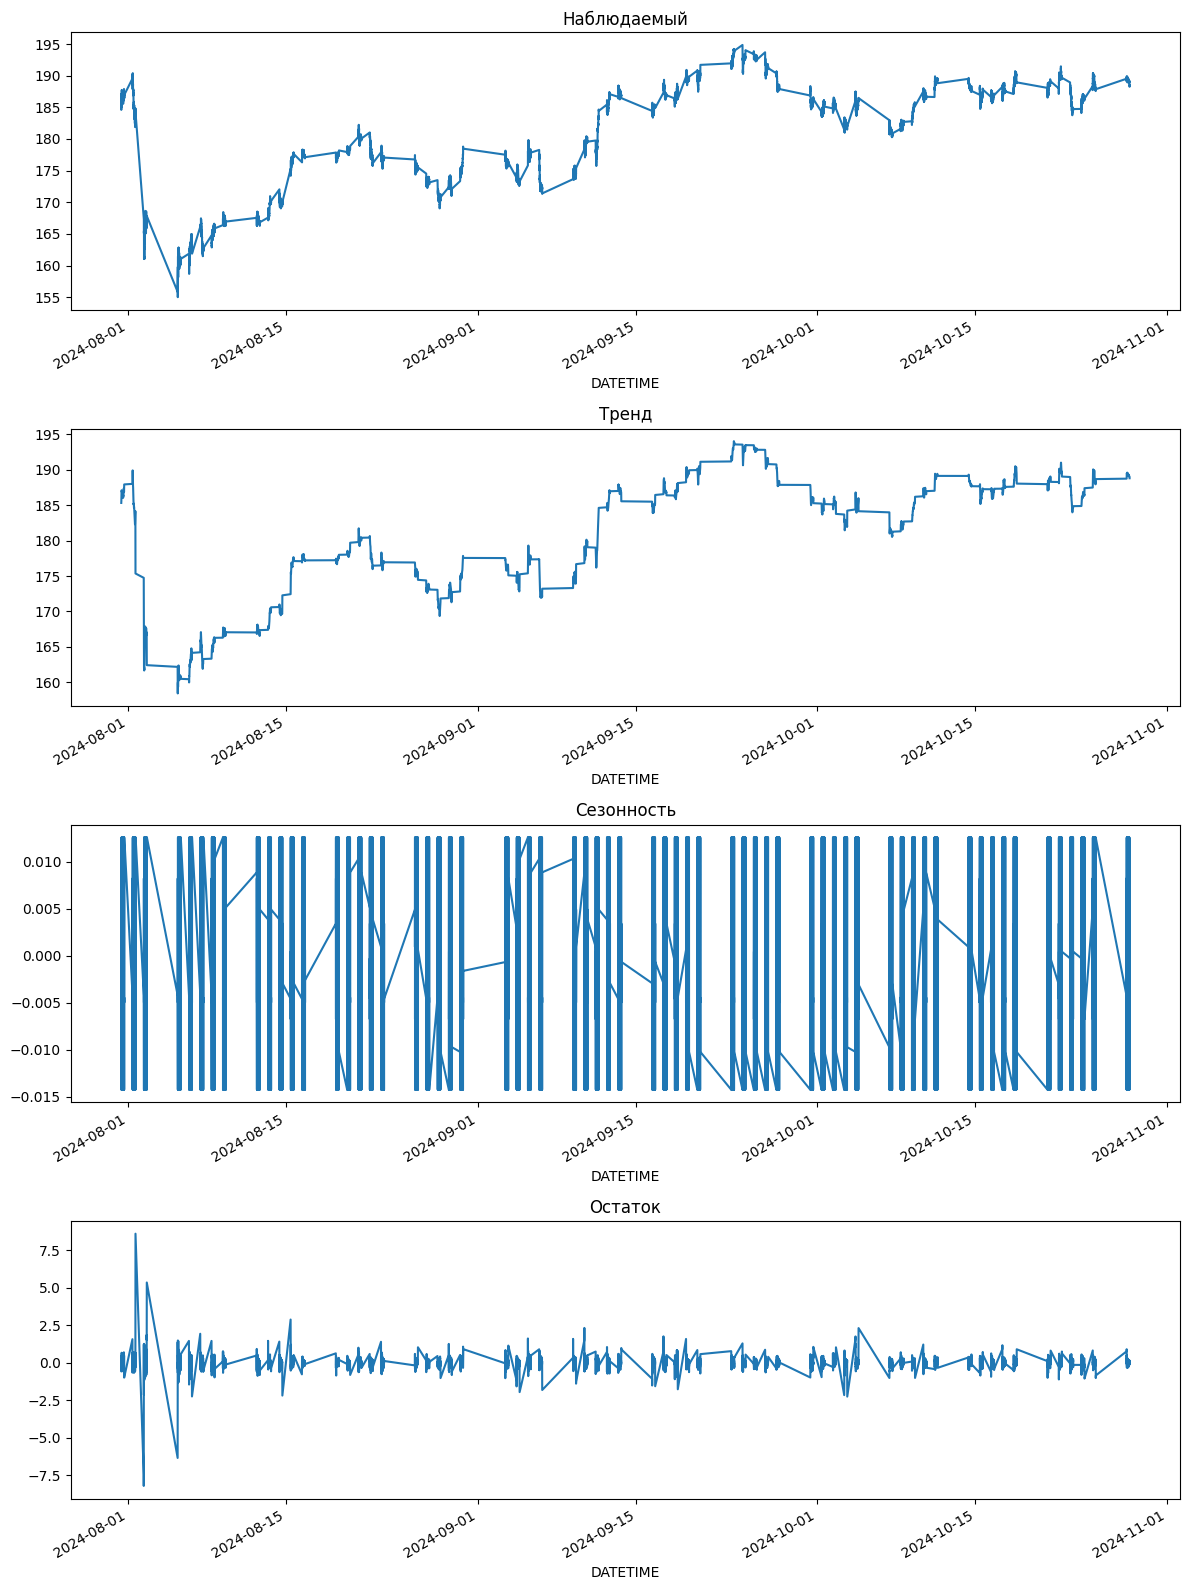

ADF Statistic: -1.894774
p-value: 0.334523
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


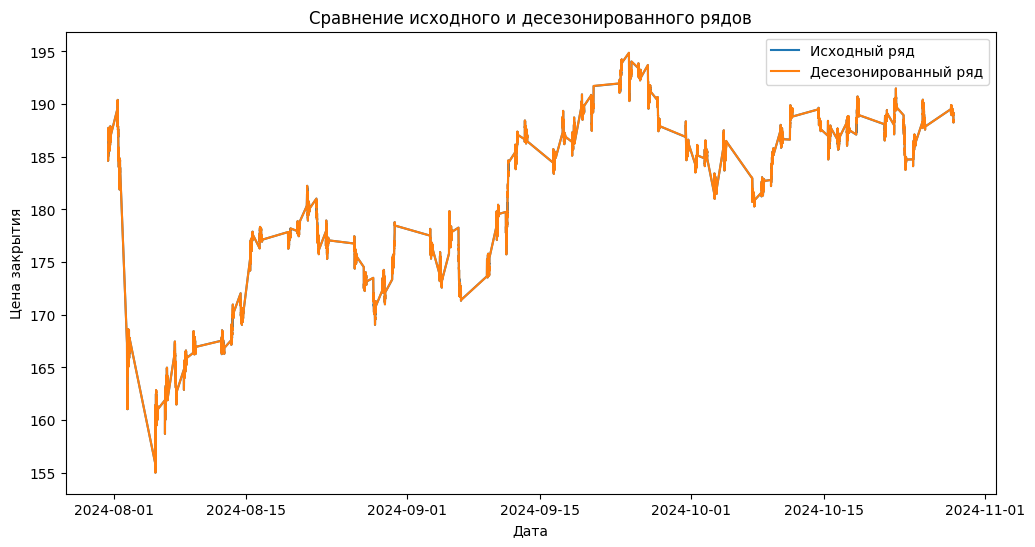

ARIMA(0, 0, 0) MAE=0.076 RMSE=0.116
ARIMA(0, 0, 1) MAE=0.076 RMSE=0.116
ARIMA(0, 0, 2) MAE=0.076 RMSE=0.116
ARIMA(0, 1, 0) MAE=0.076 RMSE=0.116
ARIMA(0, 1, 1) MAE=0.076 RMSE=0.116
ARIMA(0, 1, 2) MAE=0.076 RMSE=0.116
ARIMA(1, 0, 0) MAE=0.076 RMSE=0.116
ARIMA(1, 0, 1) MAE=0.076 RMSE=0.116
ARIMA(1, 0, 2) MAE=0.076 RMSE=0.116
ARIMA(1, 1, 0) MAE=0.076 RMSE=0.116
ARIMA(1, 1, 1) MAE=0.076 RMSE=0.116
ARIMA(1, 1, 2) MAE=0.076 RMSE=0.116
ARIMA(2, 0, 0) MAE=0.076 RMSE=0.116
ARIMA(2, 0, 1) MAE=0.076 RMSE=0.116
ARIMA(2, 0, 2) MAE=0.076 RMSE=0.116
ARIMA(2, 1, 0) MAE=0.077 RMSE=0.116
ARIMA(2, 1, 1) MAE=0.076 RMSE=0.116
ARIMA(2, 1, 2) MAE=0.076 RMSE=0.116
Лучшая модель ARIMA(1, 1, 1) MAE=0.076


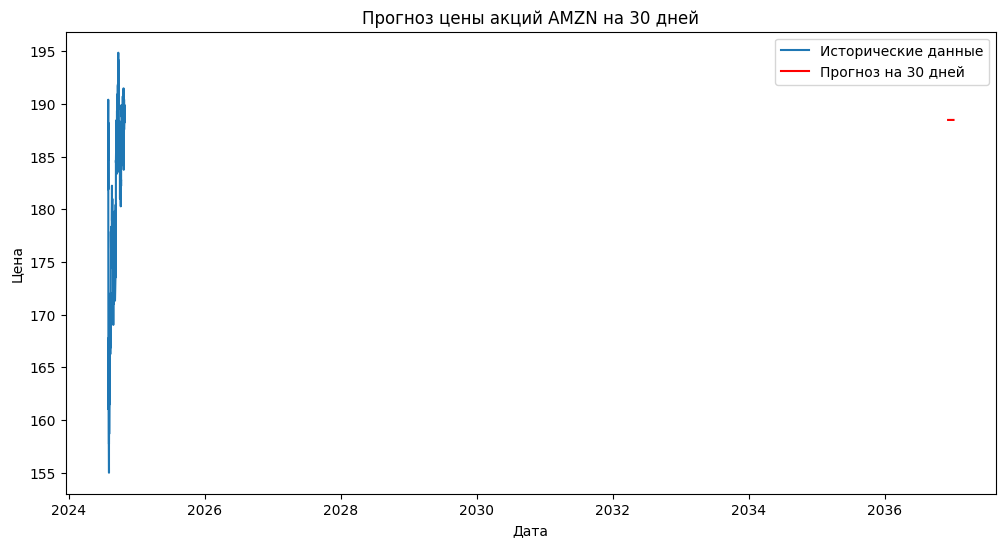

In [28]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime

# 1. Загрузка данных и предобработка
data = pd.read_csv("/content/drive/MyDrive/AMZN.csv", sep=";", header=None, names=["DATE", "TIME", "OPEN", "HIGH", "LOW", "CLOSE", "VOL"])
data['DATETIME'] = pd.to_datetime(data['DATE'].astype(str) + data['TIME'].astype(str), format='%y%m%d%H%M%S')
data.sort_values(by="DATETIME", inplace=True)
data.set_index("DATETIME", inplace=True)

# Используем цену закрытия для анализа
price_series = data['CLOSE']

# 2. Визуализация временного ряда
plt.figure(figsize=(12, 6))
plt.plot(price_series)
plt.title('Цена закрытия акций AMZN')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.show()

# 3. Декомпозиция временного ряда
decomposition = seasonal_decompose(price_series, model='additive', period=30)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Наблюдаемый')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Тренд')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Сезонность')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Остаток')
plt.tight_layout()
plt.show()

# 4. Тест на стационарность (тест Дики-Фуллера)
def adf_test(series):
    result = adfuller(series.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

adf_test(price_series)

# Приведение к стационарному виду (если необходимо)
price_diff = price_series.diff().dropna() if adfuller(price_series.dropna())[1] > 0.05 else price_series

# 5. Десезонирование ряда
seasonal_component = decomposition.seasonal
deseasonalized = price_series - seasonal_component

# Визуализация десезонированного ряда
plt.figure(figsize=(12, 6))
plt.plot(price_series, label='Исходный ряд')
plt.plot(deseasonalized, label='Десезонированный ряд')
plt.legend()
plt.title('Сравнение исходного и десезонированного рядов')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.show()

# 6. Оптимизация модели ARIMA
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.8)
    train, test = X[:train_size], X[train_size:]
    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    return mae, rmse

# Подбор лучших параметров ARIMA
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
best_score, best_cfg = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(price_diff, order)
                if mae < best_score:
                    best_score, best_cfg = mae, order
                print(f'ARIMA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue
print(f'Лучшая модель ARIMA{best_cfg} MAE={best_score:.3f}')

# 7. Прогнозирование на основе лучшей модели ARIMA
model = ARIMA(price_series, order=best_cfg)
model_fit = model.fit()
forecast = model_fit.forecast(steps=30)

plt.figure(figsize=(12, 6))
plt.plot(price_series.index, price_series, label='Исторические данные')
plt.plot(forecast.index, forecast, color='red', label='Прогноз на 30 дней')
plt.title('Прогноз цены акций AMZN на 30 дней')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()


AR модель: MAE=0.063, RMSE=0.091
MA модель: MAE=0.063, RMSE=0.091
ARMA модель: MAE=0.063, RMSE=0.091
ARIMA модель: MAE=0.063, RMSE=0.091


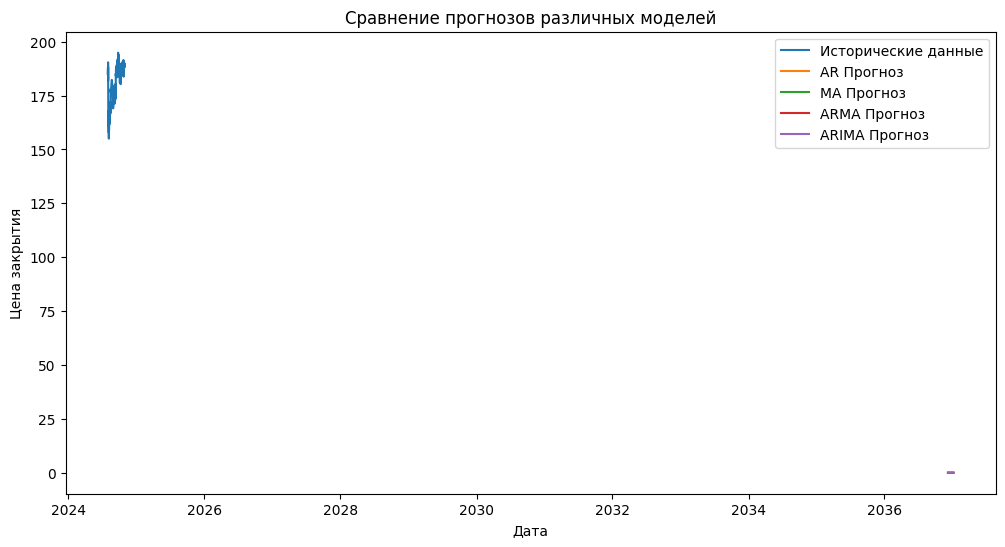

In [29]:
# 8. Сравнение моделей AR, MA, ARMA и ARIMA
from statsmodels.tsa.ar_model import AutoReg

models = {
    'AR': AutoReg,  # AR model only takes `lags` parameter
    'MA': lambda y, order: ARIMA(y, order=(0, 0, order)),  # For MA, use ARIMA with p=0, d=0
    'ARMA': lambda y, order: ARIMA(y, order=(order[0], 0, order[1])),  # ARMA, with d=0
    'ARIMA': ARIMA  # Full ARIMA model
}

orders = {
    'AR': (2,),  # Lags for AR model
    'MA': 2,     # Order for MA component only (AR=0, d=0, MA=2)
    'ARMA': (2, 2),  # ARMA(p=2, q=2) with d=0
    'ARIMA': best_cfg  # Best found order from previous tuning
}

results = {}
for name, model_func in models.items():
    try:
        if name == 'AR':
            # AR model with specified lag
            mod = model_func(price_diff, lags=orders[name][0])
        elif name == 'MA':
            # MA model using ARIMA with p=0, d=0
            mod = model_func(price_diff, orders[name])
        elif name == 'ARMA':
            # ARMA model with specified p and q, d=0
            mod = model_func(price_diff, orders[name])
        else:
            # Full ARIMA model
            mod = model_func(price_diff, order=orders[name])

        # Fit model and forecast
        fit = mod.fit()
        forecast = fit.forecast(steps=30)

        # Calculate evaluation metrics
        mae = mean_absolute_error(price_diff[-30:], forecast)
        rmse = np.sqrt(mean_squared_error(price_diff[-30:], forecast))

        # Store results
        results[name] = {'MAE': mae, 'RMSE': rmse}
        print(f'{name} модель: MAE={mae:.3f}, RMSE={rmse:.3f}')

    except Exception as e:
        print(f'Ошибка при построении {name} модели: {e}')

# 9. Визуализация прогнозов для всех моделей
plt.figure(figsize=(12, 6))
plt.plot(price_series.index, price_series, label='Исторические данные')
for name, res in results.items():
    plt.plot(range(len(price_series), len(price_series) + 30), forecast[:30], label=f'{name} Прогноз')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()
plt.title('Сравнение прогнозов различных моделей')
plt.show()
